In [1]:
import torch
import transformers
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
models = ['t5-large', 'bert-base-uncased', 'bart-large', 'bert-large-uncased-whole-word-masking', 'bert-large-uncased', 'roberta-large']
model_freqs = {}
for model_name in models:
    print(model_name)
    if "t5" in model_name.lower():
        model = transformers.T5Model.from_pretrained(model_name).to(device)
        tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
        tokenizer.mask_token = "<extra_id_0>"
    elif "gpt" in model_name.lower():
        raise NotImplementedError
    else:
        if model_name.startswith("bart"):
            model = transformers.AutoModel.from_pretrained("facebook/" + model_name).to(device)
            tokenizer = transformers.AutoTokenizer.from_pretrained("facebook/" + model_name)
        else:
            model = transformers.AutoModel.from_pretrained(model_name).to(device)
            tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
            
    
    age_age = 0
    age_mask = 0
    age_age_by_layer = np.zeros((model.config.num_hidden_layers), dtype=int)
    age_age_by_head = np.zeros((model.config.num_hidden_layers, model.config.num_attention_heads), dtype=int)
    age_mask_by_layer = np.zeros((model.config.num_hidden_layers), dtype=int)
    age_mask_by_head = np.zeros((model.config.num_hidden_layers, model.config.num_attention_heads), dtype=int)
    for age1 in tqdm(range(40, 60)):
        for age2 in range(40, 60):
    # for age1 in tqdm(range(20, 40)):
    #     for age2 in range(20, 40):
            if age1 == age2:
                continue

            local_age_age = False
            local_age_mask = False
            input_ids = torch.tensor([tokenizer.encode(f"A {age1} year old person age is {tokenizer.mask_token} than a {age2} year old person .", add_special_tokens=True)]).to(device)
            tokenized_text = tokenizer.convert_ids_to_tokens(input_ids[0])
            with torch.no_grad():
                if model_name.startswith("bart"):
                    decoder_features, decoder_states, decoder_attns, decoder_self_norms, decoder_cross_norms, encoder_last_state, encoder_states, encoder_attns, encoder_norms = model(input_ids=input_ids, output_hidden_states=True, output_attentions=True, output_norms=True)  # BART
                    norms = encoder_norms
                elif model_name.startswith("t5"):
                    decoder_features, decoder_cache, decoder_states, decoder_attns, decoder_self_norms, decoder_cross_norms, encoder_last_state, encoder_states, encoder_attns, encoder_norms = model(input_ids=input_ids, decoder_input_ids=input_ids, output_hidden_states=True, output_attentions=True, output_norms=True)  # T5
                    norms = encoder_norms
                else: 
                    last_hidden_state, pooler_output, hidden_states, attentions, norms = model(input_ids=input_ids, output_hidden_states=True, output_attentions=True, output_norms=True)

            if "roberta" in model_name or "bart" in model_name:
                first_age = tokenized_text.index("Ġyear") - 1
                sec_age = len(tokenized_text) - 1 - tokenized_text[::-1].index("Ġyear") - 1
            elif "t5" in model_name:
                first_age = tokenized_text.index("▁year") - 1
                sec_age = len(tokenized_text) - 1 - tokenized_text[::-1].index("▁year") - 1
            else:
                first_age = tokenized_text.index("year") - 1
                sec_age = len(tokenized_text) - 1 - tokenized_text[::-1].index("year") - 1
            mask = tokenized_text.index(tokenizer.mask_token)
            for layer in range(model.config.num_hidden_layers):
                layer_age_age = False
                layer_age_mask = False
                for head in range(model.config.num_attention_heads):
                    head_norms = norms[layer][1][0][head].cpu().numpy()
                    thres = np.percentile(head_norms, 99)
                    if head_norms[first_age][sec_age] > thres and head_norms[sec_age][first_age] > thres:
                        age_age_by_head[layer][head] += 1
                        local_age_age = True
                        layer_age_age = True

                    if head_norms[first_age][mask] > thres and head_norms[sec_age][mask] > thres:
                    # if head_norms[mask][first_age] > thres and head_norms[mask][sec_age] > thres:
                        age_mask_by_head[layer][head] += 1
                        local_age_mask = True
                        layer_age_mask = True

                if layer_age_age:
                    age_age_by_layer[layer] += 1

                if layer_age_mask:
                    age_mask_by_layer[layer] += 1

            if local_age_age:
                age_age += 1
            if local_age_mask:
                age_mask += 1

    model_freqs[model_name] = (age_age, age_mask, age_age_by_layer, age_mask_by_layer, age_age_by_head, age_mask_by_head)

t5-large


Some weights of T5Model were not initialized from the model checkpoint at t5-large and are newly initialized: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/20 [00:00<?, ?it/s]

bert-base-uncased


  0%|          | 0/20 [00:00<?, ?it/s]

bart-large


  0%|          | 0/20 [00:00<?, ?it/s]

bert-large-uncased-whole-word-masking


  0%|          | 0/20 [00:00<?, ?it/s]

bert-large-uncased


  0%|          | 0/20 [00:00<?, ?it/s]

roberta-large


  0%|          | 0/20 [00:00<?, ?it/s]

In [67]:
# model_name = "bert-base-uncased"
# model_name = "facebook/bart-large"
# model_name = "bert-large-uncased-whole-word-masking"
# model_name = "bert-large-uncased"
# model_name = "roberta-large"
model_name = "t5-large"
if "t5" in model_name.lower():
    model = transformers.T5Model.from_pretrained(model_name).to(device)
    tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
    tokenizer.mask_token = "<extra_id_0>"
elif "gpt" in model_name.lower():
    raise NotImplementedError
else:
    # model = transformers.AutoModelForMaskedLM.from_pretrained(model_name).to(device)
    model = transformers.AutoModel.from_pretrained(model_name).to(device)
    tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

Some weights of T5Model were not initialized from the model checkpoint at t5-large and are newly initialized: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [70]:
age_age = 0
age_mask = 0
age_age_by_layer = np.zeros((model.config.num_hidden_layers), dtype=int)
age_age_by_head = np.zeros((model.config.num_hidden_layers, model.config.num_attention_heads), dtype=int)
age_mask_by_layer = np.zeros((model.config.num_hidden_layers), dtype=int)
age_mask_by_head = np.zeros((model.config.num_hidden_layers, model.config.num_attention_heads), dtype=int)
for age1 in tqdm(range(40, 60)):
    for age2 in range(40, 60):
# for age1 in tqdm(range(20, 40)):
#     for age2 in range(20, 40):
        if age1 == age2:
            continue

        local_age_age = False
        local_age_mask = False
        input_ids = torch.tensor([tokenizer.encode(f"A {age1} year old person age is {tokenizer.mask_token} than a {age2} year old person .", add_special_tokens=True)]).to(device)
        tokenized_text = tokenizer.convert_ids_to_tokens(input_ids[0])
        with torch.no_grad():
#            last_hidden_state, pooler_output, hidden_states, attentions, norms = model(input_ids=input_ids, output_hidden_states=True, output_attentions=True, output_norms=True)
#             decoder_features, decoder_states, decoder_attns, decoder_self_norms, decoder_cross_norms, encoder_last_state, encoder_states, encoder_attns, encoder_norms = model(input_ids=input_ids, output_hidden_states=True, output_attentions=True, output_norms=True)  # BART
            decoder_features, decoder_cache, decoder_states, decoder_attns, decoder_self_norms, decoder_cross_norms, encoder_last_state, encoder_states, encoder_attns, encoder_norms = model(input_ids=input_ids, decoder_input_ids=input_ids, output_hidden_states=True, output_attentions=True, output_norms=True)  # T5
            norms = encoder_norms
        
        if "roberta" in model_name or "bart" in model_name:
            first_age = tokenized_text.index("Ġyear") - 1
            sec_age = len(tokenized_text) - 1 - tokenized_text[::-1].index("Ġyear") - 1
        elif "t5" in model_name:
            first_age = tokenized_text.index("▁year") - 1
            sec_age = len(tokenized_text) - 1 - tokenized_text[::-1].index("▁year") - 1
        else:
            first_age = tokenized_text.index("year") - 1
            sec_age = len(tokenized_text) - 1 - tokenized_text[::-1].index("year") - 1
        mask = tokenized_text.index(tokenizer.mask_token)
        for layer in range(model.config.num_hidden_layers):
            layer_age_age = False
            layer_age_mask = False
            for head in range(model.config.num_attention_heads):
                head_norms = norms[layer][1][0][head].cpu().numpy()
                thres = np.percentile(head_norms, 99)
                if head_norms[first_age][sec_age] > thres and head_norms[sec_age][first_age] > thres:
                    age_age_by_head[layer][head] += 1
                    local_age_age = True
                    layer_age_age = True
                
                if head_norms[first_age][mask] > thres and head_norms[sec_age][mask] > thres:
                # if head_norms[mask][first_age] > thres and head_norms[mask][sec_age] > thres:
                    age_mask_by_head[layer][head] += 1
                    local_age_mask = True
                    layer_age_mask = True

            if layer_age_age:
                age_age_by_layer[layer] += 1
                
            if layer_age_mask:
                age_mask_by_layer[layer] += 1

        if local_age_age:
            age_age += 1
        if local_age_mask:
            age_mask += 1

age_age, age_mask

  0%|          | 0/20 [00:00<?, ?it/s]

(380, 380)

In [15]:
model_freqs = {}

In [16]:
total = 380

380 380


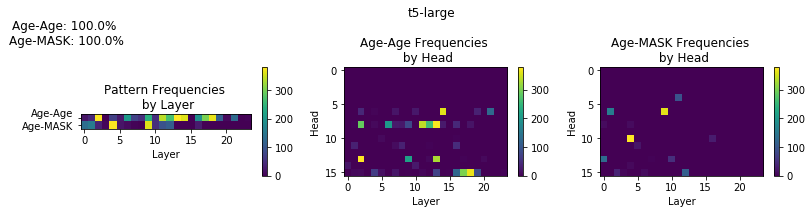

In [72]:
# (age_age, age_mask, age_age_by_layer, age_mask_by_layer, age_age_by_head, age_mask_by_head) = model_freqs[model_name]
print(age_age, age_mask)
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(13, 2))
plt.suptitle(model_name, y=1.3)
im1 = ax1.imshow(np.stack([age_age_by_layer, age_mask_by_layer]))
im2 = ax2.imshow(age_age_by_head.T)
im3 = ax3.imshow(age_mask_by_head.T)

ax1.set_title("Pattern Frequencies \n by Layer")
ax1.set_xlabel("Layer")
ax1.set_yticks([0, 1])
ax1.set_yticklabels(["Age-Age\n", "Age-MASK"])

ax2.set_title("Age-Age Frequencies \n by Head")
ax2.set_xlabel("Layer")
ax2.set_ylabel("Head")

ax3.set_title("Age-MASK Frequencies \n by Head")
ax3.set_xlabel("Layer")
ax3.set_ylabel("Head")

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
fig.colorbar(im3, ax=ax3)
plt.figtext(0.11, 1.05, f"Age-Age: {'{:.1f}'.format(age_age / total * 100)}% \n Age-MASK: {'{:.1f}%'.format(age_mask / total * 100)}", wrap=True, horizontalalignment='center', fontsize=12)
# model_freqs[model_name] = (age_age, age_mask, age_age_by_layer, age_mask_by_layer, age_age_by_head, age_mask_by_head)
plt.savefig(f"Patterns/{model_name}-40.png", bbox_inches="tight")
plt.show()

In [3]:
import pickle
with open('model_freqs-40.pkl', 'wb') as f:
    pickle.dump(model_freqs, f, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
model_freqs.keys()

dict_keys(['t5-large', 'bert-base-uncased', 'bart-large', 'bert-large-uncased-whole-word-masking', 'bert-large-uncased', 'roberta-large'])

In [2]:
import pickle
with open('model_freqs.pkl', 'rb') as f:
    model_freqs = pickle.load(f)

In [5]:
models = ['t5-large', 'bert-base-uncased', 'bart-large', 'bert-large-uncased-whole-word-masking', 'bert-large-uncased', 'roberta-large']
for model_name in models:
    model_freq = model_freqs[model_name]
    if model_name.startswith("bart"):
        model_name = "facebook/" + model_name
    try:
        layers = transformers.AutoConfig.from_pretrained(model_name).num_hidden_layers
        heads = transformers.AutoConfig.from_pretrained(model_name).num_attention_heads
    except AttributeError:
        layers = transformers.AutoConfig.from_pretrained(model_name).num_layers
        heads = transformers.AutoConfig.from_pretrained(model_name).num_heads
    print(model_name)
    print(f"Age-Age By Layer: {np.sum(model_freq[2]) / layers / 380}")
    print(f"Age-MASK By Layer: {np.sum(model_freq[3]) / layers / 380}")
    print(f"Age-Age By Head: {np.sum(model_freq[4]) / (layers * heads) / 380}")
    print(f"Age-MASK By Head: {np.sum(model_freq[5]) / (layers * heads) / 380}")
    print("---------------------")

t5-large
Age-Age By Layer: 0.39901315789473685
Age-MASK By Layer: 0.15405701754385964
Age-Age By Head: 0.031284265350877194
Age-MASK By Head: 0.009820449561403509
---------------------
bert-base-uncased
Age-Age By Layer: 0.0756578947368421
Age-MASK By Layer: 0.0008771929824561403
Age-Age By Head: 0.006304824561403509
Age-MASK By Head: 7.309941520467836e-05
---------------------
facebook/bart-large
Age-Age By Layer: 0.3048245614035088
Age-MASK By Layer: 0.00021929824561403506
Age-Age By Head: 0.031085526315789473
Age-MASK By Head: 1.3706140350877192e-05
---------------------
bert-large-uncased-whole-word-masking
Age-Age By Layer: 0.15098684210526317
Age-MASK By Layer: 0.015789473684210527
Age-Age By Head: 0.01352796052631579
Age-MASK By Head: 0.000986842105263158
---------------------
bert-large-uncased
Age-Age By Layer: 0.13925438596491227
Age-MASK By Layer: 0.04978070175438597
Age-Age By Head: 0.008908991228070175
Age-MASK By Head: 0.003111293859649123
---------------------
roberta-la

In [8]:
np.sum(model_freqs["t5-large"][2]) / 16 / 380

0.5506578947368421

In [10]:
np.sum(model_freqs["t5-large"][4])

4408

In [13]:
transformers.AutoConfig.from_pretrained("facebook/bart-large")

BartConfig {
  "activation_dropout": 0.1,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "BartModel",
    "BartForConditionalGeneration",
    "BartForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 12,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "early_stopping": true,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 12,
  "eos_token_id": 2,
  "extra_pos_embeddings": 2,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 1024,
  "model_type": "bart",
  "no_repeat_ngram_size": 3,
  "normalize_b

In [22]:
models = ['t5-large', 'bert-base-uncased', 'bart-large', 'bert-large-uncased-whole-word-masking', 'bert-large-uncased', 'roberta-large']
for model_name in models:
    if model_name.startswith("bart"):
        model_name = "facebook/" + model_name
    try:
        layers = transformers.AutoConfig.from_pretrained(model_name).num_hidden_layers
        heads = transformers.AutoConfig.from_pretrained(model_name).num_attention_heads
    except AttributeError:
        layers = transformers.AutoConfig.from_pretrained(model_name).num_layers
        heads = transformers.AutoConfig.from_pretrained(model_name).num_heads
        
    print(layers)
    print(heads)

24
16
12
12
12
16
24
16
24
16
24
16


In [17]:
layers = transformers.AutoConfig.from_pretrained("facebook/bart-large").num_hidden_layer

AttributeError: 'BartConfig' object has no attribute 'num_hidden_layer'